# 6. Batch Normalization


This tutorial is based on [CS231n Winter 2016: Lecture 5: Neural Networks Part2](https://cs231n.github.io/neural-networks-2/), [video](https://www.youtube.com/watch?v=gYpoJMlgyXA&list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC&index=5).
This [blog post](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html) is recommended.

In [1]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from net import Net
from gates import Conv,Reshape,Linear,Softmax
from optim import ADAM,SGD,Momentum,AdaGrad,RMSProb

In [2]:
def plot_images(X,y,num=4):
    print(X.shape,y.shape)
    _, axes = plt.subplots(nrows=1, ncols=num, figsize=(10, 3))
    for ax, image, label in zip(axes, X, y):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        ax.set_title(f'Label:{label}')

(1797, 8, 8) (1797,)
(1797, 1, 8, 8) (1797,)


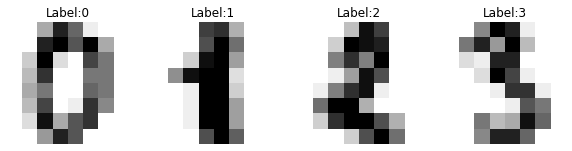

In [3]:
# Digit Recognition
digits = datasets.load_digits()
plot_images(digits.images,digits.target)

X=np.expand_dims(digits.images, axis=1)
y=digits.target
print(X.shape, y.shape)

In [4]:
np.unique(digits.images)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16.])

#### What is the number unique inputs ? TL,DR => a lot.

    . An image has 64 pixels.
    . Each pixel can take on 17 unique values (0,...,17).
    
    . Answer= $17^64$ ?

# 1. Digit Classification Benchmarking

In [5]:
def benchmarking_with_fnn(X,y,num_hidden=64,num_labels=10,num_epoch=30,num_run=10,batchsize=256):
    
    loss=[]
    acc=[]
    for i in range(num_run):
        net=Net(optimizer=ADAM(),verbose=0)
        net.add_from_iter([Reshape(flatten=True),
                           Linear(in_features=num_hidden,out_features=num_labels),
                           Softmax()])
        net.train(X,y,epoch=num_epoch,batchsize=batchsize)
        acc.append(net.acc)
        loss.append(net.losses)

    net.describe()
    _, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 8))

    for l, ac in zip(loss, acc):
        axes[0].plot(ac)
        axes[0].set_title('Avg. Acc.')

        axes[1].plot(l)
        axes[1].set_title('Avg. Loss')
        


[1. layer] => Reshape: Flatten:True, OutShape: (256, 64)
[2. layer] => Linear: W:(64, 10):Params. 650
[3. layer] => Softmax
Total param.:650


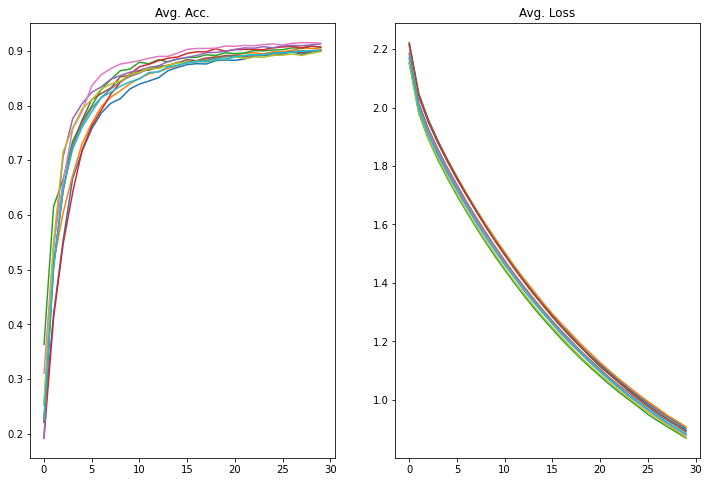

In [6]:
benchmarking_with_fnn(X=X,y=y,num_epoch=30,num_run=10,batchsize=256)

# 2. Faces recognition

(1288, 62, 47) (1288,)


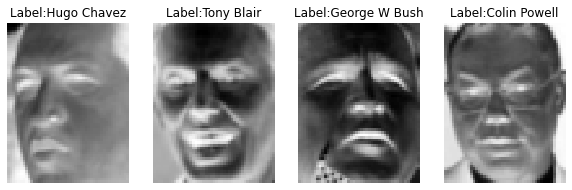

In [7]:
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=70)
X,y=lfw_people.images,lfw_people.target

plot_images(lfw_people.images, lfw_people.target_names[lfw_people.target],4)

(1288, 47, 47) (1288,)


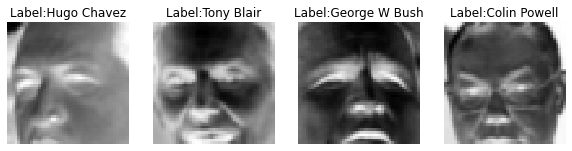

In [8]:
# Square image.
X=X[:,0:47,:]
X.shape
plot_images(X, lfw_people.target_names[lfw_people.target],4)

#### What is the number unique inputs ? TL,DR => A LOT!!!!.

    . An image has 47*47 pixels.
    . Each pixel can take on 766 unique values #len(np.unique(X_square))
    
    . Answer= $766^(47*47)$ ?

In [9]:
X=np.expand_dims(X, axis=1)
print(X.shape, y.shape)

(1288, 1, 47, 47) (1288,)


In [10]:
def random_classifier(X,y):
    pred=np.random.choice(len(np.unique(y)), len(y))
    print(f'Random Classifier [Avg.Acc:{(pred==y).mean():.3f}]')
random_classifier(X,y)

Random Classifier [Avg.Acc:0.138]


# Feed Forward Nets

[1. layer] => Reshape: Flatten:True, OutShape: (256, 2209)
[2. layer] => Linear: W:(2209, 10):Params. 22100
[3. layer] => Softmax
Total param.:22100


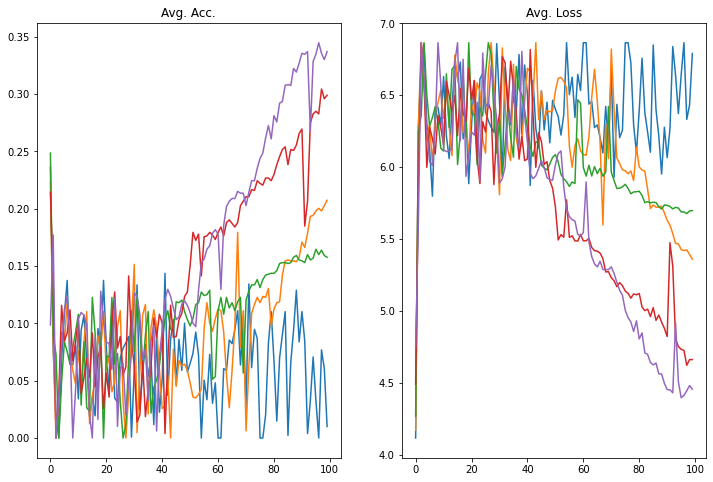

In [11]:
benchmarking_with_fnn(X=X,y=y,num_hidden=2209,num_epoch=100,num_run=5,batchsize=256)

# Batch Normalization

In [12]:
from gates import Gate
class BatchNorm(Gate):
    """
    Batch normalization.
    """
    def __init__(self,dim):
        super().__init__()
        self.eps=.001
        self.weight=np.random.randn(dim) # scale
        self.bias=np.random.randn(dim) # shift
        self.num_param=self.weight.size+ self.bias.size
        
        self.cache=None
        # Backward
        self.dweight=None
        self.dbias=None
        
        
    def __str__(self):
        return f'BatchNorm:epsilon:{self.eps}, Param.{self.param_size}'
    
    def forward(self, X):
        """
        X
        ----------
        X : shape=(N,D)

        Returns
        -------
        Z : shape (N,D)
        """
        
        N,D=X.shape
        # 1. Compute the mini-batch mean.
        mu=X.mean(axis=0)  
        
        # 2. Compute the mini-batch variance -X.var(axis=0)-.
        # 2.1
        xmu = X - mu
        # 2.2
        sq = xmu ** 2
        var = 1./N * np.sum(sq, axis = 0)
        
        #3. Compute the denominator of normalization
        sqrtvar = np.sqrt(var + self.eps)
        #3.1 invert sqrtwar
        ivar = 1./sqrtvar
        
        #4. Execute normalization
        xhat = xmu * ivar
        
        #5. Nor the two transformation steps
        gammax = self.weight*xhat#self.gamma * xhat
        
        #6.
        Z = gammax + self.bias#gammax + self.beta
        #store intermediate
        self.cache = (xhat,xmu,ivar,sqrtvar,var)        
        return Z

    def backward(self, dZ):
        N, D = dZ.shape
        xhat,xmu,ivar,sqrtvar,var=self.cache
        
        #6. 
        ## Forward: gammax + self.beta = Z 
        ## Backward: dgammax= Z and self.dbeta= Z
        self.dbias = np.sum(dZ, axis=0); assert self.dbias.shape==self.bias.shape #Sanity checking
        dgammax = dZ

        #5.
        ## Forward: self.gamma * xhat = gammax
        ## Backward: self.dgamma = dgammax * xhat and dxhat= dgammax * self.gamma
        self.dweight = np.sum(dgammax*xhat, axis=0); assert self.dweight.shape==self.weight.shape
        dxhat = dgammax * self.weight

        #4.
        divar = np.sum(dxhat*xmu, axis=0)
        dxmu1 = dxhat * ivar

        #3.(derivative of quotient) and derivative of root.
        dsqrtvar = -1. /(sqrtvar**2) * divar
        dvar = 0.5 * 1. /np.sqrt(var+self.eps) * dsqrtvar

        #2.
        dsq = 1. /N * np.ones((N,D)) * dvar

        #step3
        dxmu2 = 2 * xmu * dsq

        #step2
        dx1 = (dxmu1 + dxmu2)
        dmu = -1 * np.sum(dxmu1+dxmu2, axis=0)

        #step1
        dx2 = 1. /N * np.ones((N,D)) * dmu

        #step0
        dx = dx1 + dx2

        return dx


In [13]:
def benchmarking_with_batch_norm_fnn(X,y,num_hidden=64,num_labels=10,num_epoch=30,num_run=10,batchsize=256):
    
    loss=[]
    acc=[]
    for i in range(num_run):
        net=Net(optimizer=ADAM(),verbose=0)
        net.add_from_iter([Reshape(flatten=True),
                           Linear(in_features=num_hidden,out_features=num_labels),
                           BatchNorm(num_labels),
                           Softmax()])
        net.train(X,y,epoch=num_epoch,batchsize=batchsize)
        acc.append(net.acc)
        loss.append(net.losses)

    net.describe()
    _, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 8))

    for l, ac in zip(loss, acc):
        axes[0].plot(ac)
        axes[0].set_title('Avg. Acc.')

        axes[1].plot(l)
        axes[1].set_title('Avg. Loss')

# Benchmarking

[1. layer] => Reshape: Flatten:True, OutShape: (128, 2209)
[2. layer] => Linear: W:(2209, 10):Params. 22100
[3. layer] => Softmax
Total param.:22100


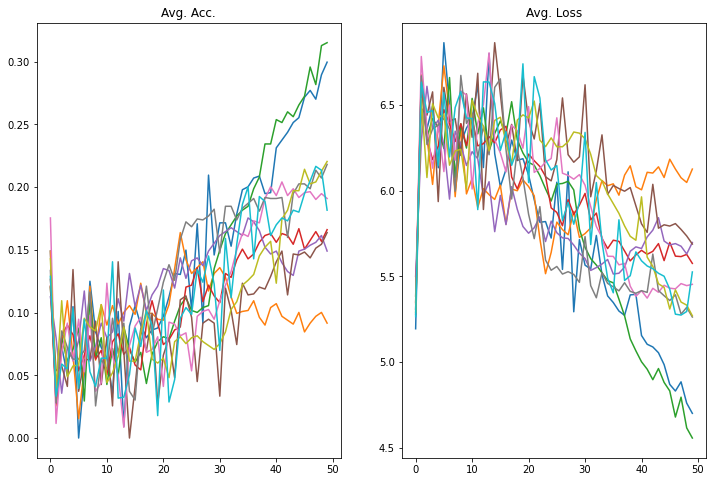

In [14]:
benchmarking_with_fnn(X=X,y=y,num_hidden=2209,num_epoch=50,num_run=10,batchsize=128)

[1. layer] => Reshape: Flatten:True, OutShape: (1024, 2209)
[2. layer] => Linear: W:(2209, 10):Params. 22100
[3. layer] => BatchNorm:epsilon:0.001, Param.20
[4. layer] => Softmax
Total param.:22120


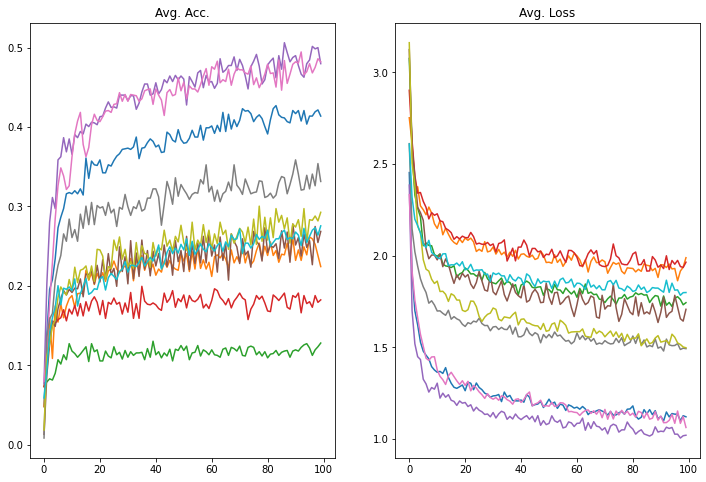

In [15]:
benchmarking_with_batch_norm_fnn(X=X,y=y,num_hidden=2209,num_epoch=100,num_run=10,batchsize=1024)